# MIE 1624 Assignment 2: Regression
## --- "2018 Kaggle ML & DS Survey Challenge"
##### !!! The 10-fold cross-validation and the hyperparameter tuning were NOT commented out, though they didn't take much time.

## Section 0: Preparation
In this section, the data as well as the required libraries wer loaded.

In [204]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os

from sklearn import preprocessing 
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import linear_model
from sklearn.feature_selection import RFE
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import make_scorer, r2_score, mean_squared_error, auc, mean_absolute_error
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.neural_network import MLPRegressor

In [205]:
salary = pd.read_csv("kaggle_salary.csv", low_memory = False)

In [206]:
salary.head(10)

,Unnamed: 0,Time from Start to Finish (seconds),Q1,Q1_OTHER_TEXT,Q2,Q3,Q4,Q5,Q6,Q6_OTHER_TEXT,...,Q50_Part_1,Q50_Part_2,Q50_Part_3,Q50_Part_4,Q50_Part_5,Q50_Part_6,Q50_Part_7,Q50_Part_8,Q50_OTHER_TEXT,index
0,0,Duration (in seconds),What is your gender? - Selected Choice,What is your gender? - Prefer to self-describe...,What is your age (# years)?,In which country do you currently reside?,What is the highest level of formal education ...,Which best describes your undergraduate major?...,Select the title most similar to your current ...,Select the title most similar to your current ...,...,What barriers prevent you from making your wor...,What barriers prevent you from making your wor...,What barriers prevent you from making your wor...,What barriers prevent you from making your wor...,What barriers prevent you from making your wor...,What barriers prevent you from making your wor...,What barriers prevent you from making your wor...,What barriers prevent you from making your wor...,What barriers prevent you from making your wor...,NaN
1,2,434,Male,-1,30-34,Indonesia,Bachelor’s degree,Engineering (non-computer focused),Other,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,0.0
2,3,718,Female,-1,30-34,United States of America,Master’s degree,"Computer science (software engineering, etc.)",Data Scientist,-1,...,NaN,Too time-consuming,NaN,NaN,NaN,NaN,NaN,NaN,-1,1.0
3,5,731,Male,-1,22-24,India,Master’s degree,Mathematics or statistics,Data Analyst,-1,...,NaN,Too time-consuming,NaN,NaN,Not enough incentives to share my work,NaN,NaN,NaN,-1,2.0
4,7,959,Male,-1,35-39,Chile,Doctoral degree,"Information technology, networking, or system ...",Other,1,...,Too expensive,NaN,NaN,NaN,NaN,I had never considered making my work easier f...,NaN,NaN,-1,3.0
5,8,1758,Male,-1,18-21,India,Master’s degree,"Information technology, networking, or system ...",Other,2,...,NaN,NaN,NaN,NaN,Not enough incentives to share my work,NaN,NaN,NaN,-1,4.0
6,10,751,Male,-1,30-34,Hungary,Master’s degree,Engineering (non-computer focused),Software Engineer,-1,...,NaN,Too time-consuming,NaN,Afraid that others will use my work without gi...,NaN,NaN,NaN,NaN,-1,5.0
7,12,823,Male,-1,40-44,United States of America,Master’s degree,Engineering (non-computer focused),Data Scientist,-1,...,NaN,Too time-consuming,NaN,NaN,Not enough incentives to share my work,NaN,NaN,NaN,-1,6.0
8,13,1091,Male,-1,25-29,France,Doctoral degree,Mathematics or statistics,Student,-1,...,NaN,NaN,NaN,NaN,NaN,NaN,None of these reasons apply to me,NaN,-1,7.0
9,14,1917,Male,-1,25-29,United States of America,Bachelor’s degree,Mathematics or statistics,Research Assistant,-1,...,NaN,Too time-consuming,NaN,NaN,NaN,NaN,NaN,NaN,-1,8.0


In [207]:
salary.Q1.value_counts()

Male                                      12866
Female                                     2380
Prefer not to say                           130
Prefer to self-describe                      53
What is your gender? - Selected Choice        1
Name: Q1, dtype: int64

In [208]:
salary.shape

(15430, 397)

## Section 1: Data Cleaning

The goal of this section is to prepare the data for future analysis, further "cleaning" of the data (feature engineering) was performed in Section 3. The following actions were taken in this section (not in order):


1. Drop column 'Q9' from the dataframe: this column contains the target variables and was pre-modified, therefore should not be altered again. 


2. Drop empty columns as they don't contribute to results; drop the 'Unnamed: 0' and 'index' columns as these columns represent nothing for the model; drop the 'index' row as this row contains the questions which will cause questions when building the models; drop any column with 'OTHER_TEXT' as these serve as the alternatives for the multiple questions but only contain meaningless numbers, so it's assumed that the absence of these columns will not have significant impact on the model's accuracy; drop column 'Time from Start to Finish' as this column contains the time it took to complete the survey which is assumed to be random and have negligible effects on the target value.


3. Handle missing values. The questions (or columns in this case) in this survey were seperated into 2 categories: multiple choices in one column and multiple choices in several columns. A 'NaN' in the first category represents a missing value, whereas in the second category, it could mean that the person didn't select that choice. Therefore, when handling missing values, only the first category was taken care of. For the second category, the 'NaN's were replaced by the word'Nope' for future encoding.
   
   For a column in the first category, if only 1% of its values were missing, then the row with missing value was dropped, since the effect of the action would cause is minimal; if more than 40% of its value were missing, then this column would not be considered as a feature when building the model since too many missing data would affect the resulting model; otherwise, the missing values were assigned the mode of the categorical data. 
   
   Details and special cases were discussed below.


4. Convert categorical data into numerical data by encoding. For this part, LabelEncoder was used. Since this survey was all multiple choices and the majority of the columns were just "yes / no", LabelEncoder could easily transfer that into 0 / 1. As to the columns that contained more than just "yes/no", LabelEncoder could also assign each value a number.    

In [209]:
# remove the row that contains the questions
salary.drop([0],inplace=True)
print(salary.shape)
salary.head()

(15429, 397)


,Unnamed: 0,Time from Start to Finish (seconds),Q1,Q1_OTHER_TEXT,Q2,Q3,Q4,Q5,Q6,Q6_OTHER_TEXT,...,Q50_Part_1,Q50_Part_2,Q50_Part_3,Q50_Part_4,Q50_Part_5,Q50_Part_6,Q50_Part_7,Q50_Part_8,Q50_OTHER_TEXT,index
1,2,434,Male,-1,30-34,Indonesia,Bachelor’s degree,Engineering (non-computer focused),Other,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,0.0
2,3,718,Female,-1,30-34,United States of America,Master’s degree,"Computer science (software engineering, etc.)",Data Scientist,-1,...,NaN,Too time-consuming,NaN,NaN,NaN,NaN,NaN,NaN,-1,1.0
3,5,731,Male,-1,22-24,India,Master’s degree,Mathematics or statistics,Data Analyst,-1,...,NaN,Too time-consuming,NaN,NaN,Not enough incentives to share my work,NaN,NaN,NaN,-1,2.0
4,7,959,Male,-1,35-39,Chile,Doctoral degree,"Information technology, networking, or system ...",Other,1,...,Too expensive,NaN,NaN,NaN,NaN,I had never considered making my work easier f...,NaN,NaN,-1,3.0
5,8,1758,Male,-1,18-21,India,Master’s degree,"Information technology, networking, or system ...",Other,2,...,NaN,NaN,NaN,NaN,Not enough incentives to share my work,NaN,NaN,NaN,-1,4.0


In [210]:
# drop the columns with 'OTHER_TEXT' in them
cols = [c for c in salary.columns if c[-10:] != 'OTHER_TEXT']
salary = salary[cols]
salary.head()

,Unnamed: 0,Time from Start to Finish (seconds),Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,...,Q49_Part_12,Q50_Part_1,Q50_Part_2,Q50_Part_3,Q50_Part_4,Q50_Part_5,Q50_Part_6,Q50_Part_7,Q50_Part_8,index
1,2,434,Male,30-34,Indonesia,Bachelor’s degree,Engineering (non-computer focused),Other,Manufacturing/Fabrication,5-10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,3,718,Female,30-34,United States of America,Master’s degree,"Computer science (software engineering, etc.)",Data Scientist,I am a student,0-1,...,NaN,NaN,Too time-consuming,NaN,NaN,NaN,NaN,NaN,NaN,1.0
3,5,731,Male,22-24,India,Master’s degree,Mathematics or statistics,Data Analyst,I am a student,0-1,...,NaN,NaN,Too time-consuming,NaN,NaN,Not enough incentives to share my work,NaN,NaN,NaN,2.0
4,7,959,Male,35-39,Chile,Doctoral degree,"Information technology, networking, or system ...",Other,Academics/Education,10-15,...,NaN,Too expensive,NaN,NaN,NaN,NaN,I had never considered making my work easier f...,NaN,NaN,3.0
5,8,1758,Male,18-21,India,Master’s degree,"Information technology, networking, or system ...",Other,Other,0-1,...,NaN,NaN,NaN,NaN,NaN,Not enough incentives to share my work,NaN,NaN,NaN,4.0


In [211]:
# drop the three insignificant columns 
salary = salary.drop(columns = ['Unnamed: 0', 'Time from Start to Finish (seconds)', 'index'])
salary.head()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,Q49_Part_11,Q49_Part_12,Q50_Part_1,Q50_Part_2,Q50_Part_3,Q50_Part_4,Q50_Part_5,Q50_Part_6,Q50_Part_7,Q50_Part_8
1,Male,30-34,Indonesia,Bachelor’s degree,Engineering (non-computer focused),Other,Manufacturing/Fabrication,5-10,18668,No (we do not use ML methods),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Female,30-34,United States of America,Master’s degree,"Computer science (software engineering, etc.)",Data Scientist,I am a student,0-1,2726,I do not know,...,NaN,NaN,NaN,Too time-consuming,NaN,NaN,NaN,NaN,NaN,NaN
3,Male,22-24,India,Master’s degree,Mathematics or statistics,Data Analyst,I am a student,0-1,682,I do not know,...,NaN,NaN,NaN,Too time-consuming,NaN,NaN,Not enough incentives to share my work,NaN,NaN,NaN
4,Male,35-39,Chile,Doctoral degree,"Information technology, networking, or system ...",Other,Academics/Education,10-15,11957,No (we do not use ML methods),...,NaN,NaN,Too expensive,NaN,NaN,NaN,NaN,I had never considered making my work easier f...,NaN,NaN
5,Male,18-21,India,Master’s degree,"Information technology, networking, or system ...",Other,Other,0-1,2696,"We recently started using ML methods (i.e., mo...",...,NaN,NaN,NaN,NaN,NaN,NaN,Not enough incentives to share my work,NaN,NaN,NaN


In [212]:
# drop empty columns
salary = salary.dropna(axis=1, how='all')
salary.head()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,Q49_Part_11,Q49_Part_12,Q50_Part_1,Q50_Part_2,Q50_Part_3,Q50_Part_4,Q50_Part_5,Q50_Part_6,Q50_Part_7,Q50_Part_8
1,Male,30-34,Indonesia,Bachelor’s degree,Engineering (non-computer focused),Other,Manufacturing/Fabrication,5-10,18668,No (we do not use ML methods),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Female,30-34,United States of America,Master’s degree,"Computer science (software engineering, etc.)",Data Scientist,I am a student,0-1,2726,I do not know,...,NaN,NaN,NaN,Too time-consuming,NaN,NaN,NaN,NaN,NaN,NaN
3,Male,22-24,India,Master’s degree,Mathematics or statistics,Data Analyst,I am a student,0-1,682,I do not know,...,NaN,NaN,NaN,Too time-consuming,NaN,NaN,Not enough incentives to share my work,NaN,NaN,NaN
4,Male,35-39,Chile,Doctoral degree,"Information technology, networking, or system ...",Other,Academics/Education,10-15,11957,No (we do not use ML methods),...,NaN,NaN,Too expensive,NaN,NaN,NaN,NaN,I had never considered making my work easier f...,NaN,NaN
5,Male,18-21,India,Master’s degree,"Information technology, networking, or system ...",Other,Other,0-1,2696,"We recently started using ML methods (i.e., mo...",...,NaN,NaN,NaN,NaN,NaN,NaN,Not enough incentives to share my work,NaN,NaN,NaN


Below is the list of all the columns that fall into the first category (where 'NaN's are considered as missing values). Some special cases worth mentioning: columns 'Q12_Part_1_TEXT' to 'Q12_Part_5_TEXT' were dropped since they contain meaningless intergers; column 'Q9' was the target variables and were premodifed, therefore it's considered to be 'perfect' aka no need for cleaning.

In [213]:
first_category = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q10', 'Q12', 'Q22', 'Q23', 'Q24', 'Q25',
                  'Q26','Q34_Part_1', 'Q34_Part_2', 'Q34_Part_3', 'Q34_Part_4', 'Q34_Part_5', 'Q34_Part_6', 
                  'Q35_Part_1', 'Q35_Part_2', 'Q35_Part_3', 'Q35_Part_4', 'Q35_Part_5', 'Q35_Part_6',
                  'Q39_Part_1', 'Q39_Part_2', 'Q40', 'Q41_Part_1', 'Q41_Part_2', 'Q41_Part_3', 'Q43', 'Q46',
                  'Q48', 'Q12_MULTIPLE_CHOICE']

In [214]:
# drop the other columns of Q12
salary = salary.drop(columns=['Q12_Part_1_TEXT','Q12_Part_2_TEXT','Q12_Part_3_TEXT',
                              'Q12_Part_4_TEXT','Q12_Part_5_TEXT'])
salary.head()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,Q49_Part_11,Q49_Part_12,Q50_Part_1,Q50_Part_2,Q50_Part_3,Q50_Part_4,Q50_Part_5,Q50_Part_6,Q50_Part_7,Q50_Part_8
1,Male,30-34,Indonesia,Bachelor’s degree,Engineering (non-computer focused),Other,Manufacturing/Fabrication,5-10,18668,No (we do not use ML methods),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Female,30-34,United States of America,Master’s degree,"Computer science (software engineering, etc.)",Data Scientist,I am a student,0-1,2726,I do not know,...,NaN,NaN,NaN,Too time-consuming,NaN,NaN,NaN,NaN,NaN,NaN
3,Male,22-24,India,Master’s degree,Mathematics or statistics,Data Analyst,I am a student,0-1,682,I do not know,...,NaN,NaN,NaN,Too time-consuming,NaN,NaN,Not enough incentives to share my work,NaN,NaN,NaN
4,Male,35-39,Chile,Doctoral degree,"Information technology, networking, or system ...",Other,Academics/Education,10-15,11957,No (we do not use ML methods),...,NaN,NaN,Too expensive,NaN,NaN,NaN,NaN,I had never considered making my work easier f...,NaN,NaN
5,Male,18-21,India,Master’s degree,"Information technology, networking, or system ...",Other,Other,0-1,2696,"We recently started using ML methods (i.e., mo...",...,NaN,NaN,NaN,NaN,NaN,NaN,Not enough incentives to share my work,NaN,NaN,NaN


In [215]:
salary.shape

(15429, 358)

In [216]:
one_percent = []
for c in salary.columns:
    if c in first_category:
        NullNum = salary[c].isnull().sum()
        if (NullNum > 0) & (0.01 * 15429 >= NullNum):
            one_percent.append(c)
print("Columns with less than 1% missing value: ",one_percent)

Columns with less than 1% missing value:  ['Q5', 'Q8']


In [217]:
for c in one_percent:
    salary.dropna(subset=[c],inplace=True)
salary.shape

(15219, 358)

As shown above, 210 rows were dropped, compared to the remaining 15219 rows, this number was considered insignificant.

In [218]:
fourty_percent = []
for c in salary.columns:
    if c in first_category:
        NullNum = salary[c].isnull().sum()
        if (0.4 * 15219 <= NullNum):
            fourty_percent.append(c)
print("Columns with more than 40% missing value: ",fourty_percent)

Columns with more than 40% missing value:  ['Q22']


As shown above, column 'Q22' had more than 40% missing data, therefore it was not taken into account when building the model.

In [219]:
other_percent = []
for c in salary.columns:
    if c in first_category:
        NullNum = salary[c].isnull().sum()
        if (0.4 * 15219 > NullNum) & (0.01 * 15219 < NullNum):
            other_percent.append(c)
print("Other columns are: ",other_percent)

Other columns are:  ['Q10', 'Q12_MULTIPLE_CHOICE', 'Q23', 'Q24', 'Q25', 'Q26', 'Q34_Part_1', 'Q34_Part_2', 'Q34_Part_3', 'Q34_Part_4', 'Q34_Part_5', 'Q34_Part_6', 'Q35_Part_1', 'Q35_Part_2', 'Q35_Part_3', 'Q35_Part_4', 'Q35_Part_5', 'Q35_Part_6', 'Q39_Part_1', 'Q39_Part_2', 'Q40', 'Q41_Part_1', 'Q41_Part_2', 'Q41_Part_3', 'Q43', 'Q46', 'Q48']


In [220]:
for c in other_percent:
    salary[c].fillna(salary[c].mode()[0],inplace=True)

In [221]:
# drop the target varaible and columns 'Q22'
Y = salary['Q9']
salary = salary.drop(['Q9', 'Q22'], axis=1)
salary.shape

(15219, 356)

In [222]:
for c in salary.columns:
    salary[c].fillna('Nope', inplace=True)

In [223]:
salary.head()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q10,Q11_Part_1,...,Q49_Part_11,Q49_Part_12,Q50_Part_1,Q50_Part_2,Q50_Part_3,Q50_Part_4,Q50_Part_5,Q50_Part_6,Q50_Part_7,Q50_Part_8
1,Male,30-34,Indonesia,Bachelor’s degree,Engineering (non-computer focused),Other,Manufacturing/Fabrication,5-10,No (we do not use ML methods),Nope,...,Nope,Nope,Nope,Nope,Nope,Nope,Nope,Nope,Nope,Nope
2,Female,30-34,United States of America,Master’s degree,"Computer science (software engineering, etc.)",Data Scientist,I am a student,0-1,I do not know,Analyze and understand data to influence produ...,...,Nope,Nope,Nope,Too time-consuming,Nope,Nope,Nope,Nope,Nope,Nope
3,Male,22-24,India,Master’s degree,Mathematics or statistics,Data Analyst,I am a student,0-1,I do not know,Nope,...,Nope,Nope,Nope,Too time-consuming,Nope,Nope,Not enough incentives to share my work,Nope,Nope,Nope
4,Male,35-39,Chile,Doctoral degree,"Information technology, networking, or system ...",Other,Academics/Education,10-15,No (we do not use ML methods),Nope,...,Nope,Nope,Too expensive,Nope,Nope,Nope,Nope,I had never considered making my work easier f...,Nope,Nope
5,Male,18-21,India,Master’s degree,"Information technology, networking, or system ...",Other,Other,0-1,"We recently started using ML methods (i.e., mo...",Nope,...,Nope,Nope,Nope,Nope,Nope,Nope,Not enough incentives to share my work,Nope,Nope,Nope


In [224]:
le = LabelEncoder()
for answer in salary:
        salary[answer]=le.fit_transform(salary[answer].astype(str))

In [225]:
salary.head()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q10,Q11_Part_1,...,Q49_Part_11,Q49_Part_12,Q50_Part_1,Q50_Part_2,Q50_Part_3,Q50_Part_4,Q50_Part_5,Q50_Part_6,Q50_Part_7,Q50_Part_8
1,1,3,22,0,2,11,9,10,1,1,...,1,0,0,0,0,1,0,1,1,0
2,0,3,56,3,1,7,7,0,0,0,...,1,0,0,1,0,1,0,1,1,0
3,1,1,21,3,8,4,7,0,0,1,...,1,0,0,1,0,1,1,1,1,0
4,1,4,8,1,7,11,0,2,1,1,...,1,0,1,0,0,1,0,0,1,0
5,1,0,21,3,7,11,16,0,4,1,...,1,0,0,0,0,1,1,1,1,0


## Section 2: Exploratory Data Analysis
In this section, as required, 3 graphical figrures were created. The yearly compansations were compared among different genders, ages and education levels. The three categories were chosen because they were all among the top concerns for people in the industry. With the help of the figures, decicions can be made to include these as features or not. Besides, these graphs also provides insights on the distribution of the yearly compansations.

In [34]:
salary_one = pd.read_csv("kaggle_salary.csv", low_memory = False)
salary_one.drop([0],inplace=True)
salary_one.shape

(15429, 397)

In [35]:
salary_one.Q9=salary_one.Q9.astype(int)

In [36]:
salary_one.rename(columns={'Q1': 'Gender', 'Q2': 'Age', 'Q4': 'Degree'},inplace=True)

Text(0, 0.5, 'Yearly Compensation')

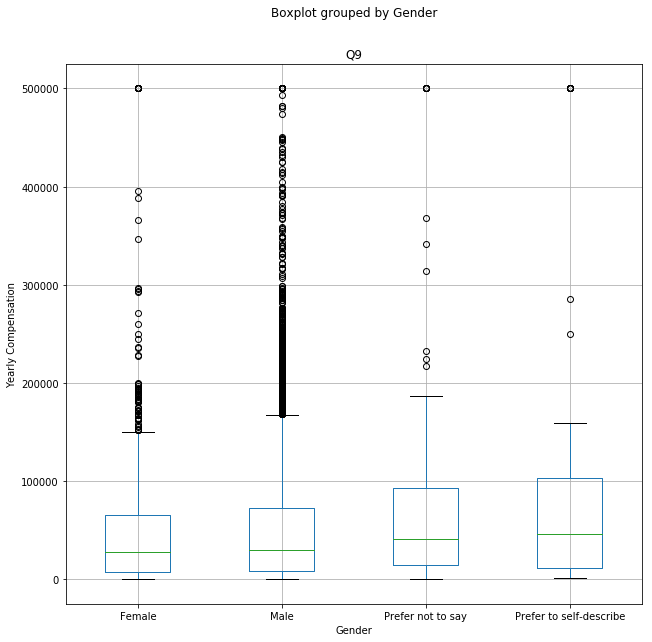

In [37]:
by_gender = salary_one.boxplot(column='Q9', by='Gender', figsize=(10,10))
plt.xlabel('Gender')
plt.ylabel('Yearly Compensation')

Text(0, 0.5, 'Yearly Compensation')

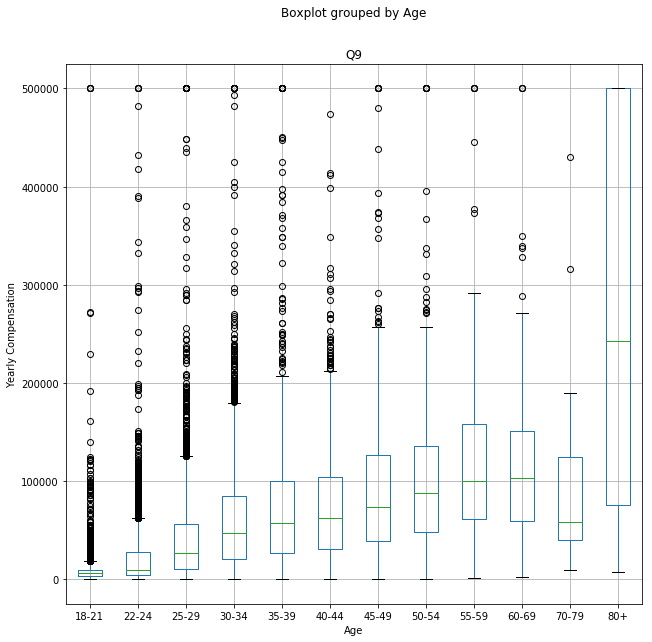

In [38]:
salary_one.boxplot(column='Q9', by='Age', figsize=(10,10))
plt.xlabel('Age')
plt.ylabel('Yearly Compensation')

Text(0, 0.5, 'Yearly Compensation')

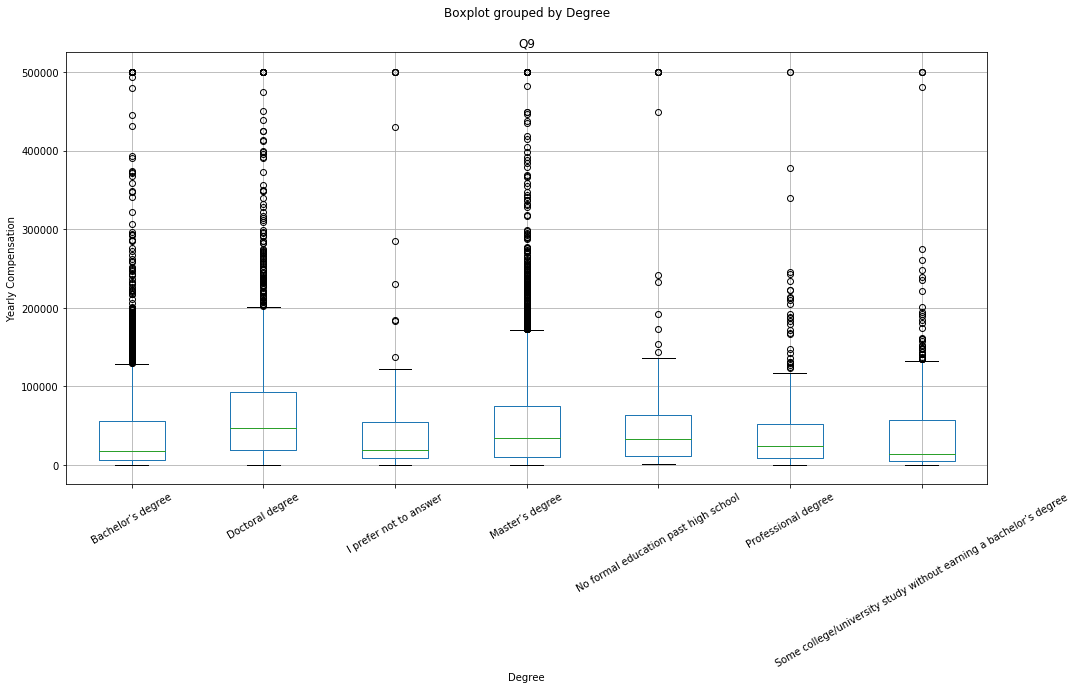

In [39]:
salary_one.boxplot(column='Q9', by='Degree', figsize=(16,8), rot=30)
plt.xlabel('Degree')
plt.ylabel('Yearly Compensation')

Base on the three graphs above, it's observed that:
1. For majority of the people working in the industry, the pay gap between male and female was insignificant. However, there were more men than women who make more money than the average.
2. As for the age, understandably, middle-age people have the highest compensation, since they probably have more experience, and are probably in the senior or management level.
3. When it comes to education level, people with PhDs tend to earn more money than the rest. It's safe to conclude that a higher education level would be beneficial in the career.

Then, the correlation between the yearly compansation and the rest of the questions were studied. A heat map was plotted to illustrate the result.

In [40]:
for c in salary_one.columns:
    salary_one[c].fillna('Nope', inplace=True)

le = LabelEncoder()
for answer in salary_one:
        salary_one[answer]=le.fit_transform(salary_one[answer].astype(str))

salary_one = salary_one.drop(columns=['Unnamed: 0', 'Time from Start to Finish (seconds)', 'index'])

cols = [c for c in salary_one.columns if c[-10:] != 'OTHER_TEXT']
salary_one = salary_one[cols]

corr = salary_one.corr()

In [41]:
corr.Q9.value_counts

<bound method IndexOpsMixin.value_counts of Gender                -0.020200
Age                   -0.091971
Q3                    -0.064069
Degree                -0.001804
Q5                     0.009184
Q6                     0.044410
Q7                     0.018965
Q8                    -0.066272
Q9                     1.000000
Q10                   -0.055452
Q11_Part_1             0.023235
Q11_Part_2             0.034693
Q11_Part_3             0.025953
Q11_Part_4             0.046950
Q11_Part_5             0.028087
Q11_Part_6            -0.011811
Q11_Part_7             0.024170
Q12_MULTIPLE_CHOICE   -0.007765
Q12_Part_1_TEXT        0.005659
Q12_Part_2_TEXT        0.019211
Q12_Part_3_TEXT        0.001203
Q12_Part_4_TEXT       -0.014663
Q12_Part_5_TEXT       -0.021335
Q13_Part_1             0.023548
Q13_Part_2            -0.001542
Q13_Part_3            -0.022585
Q13_Part_4            -0.009426
Q13_Part_5            -0.014444
Q13_Part_6             0.006577
Q13_Part_7            -0.006

Text(0.5, 1.0, 'Correlation Matrix')

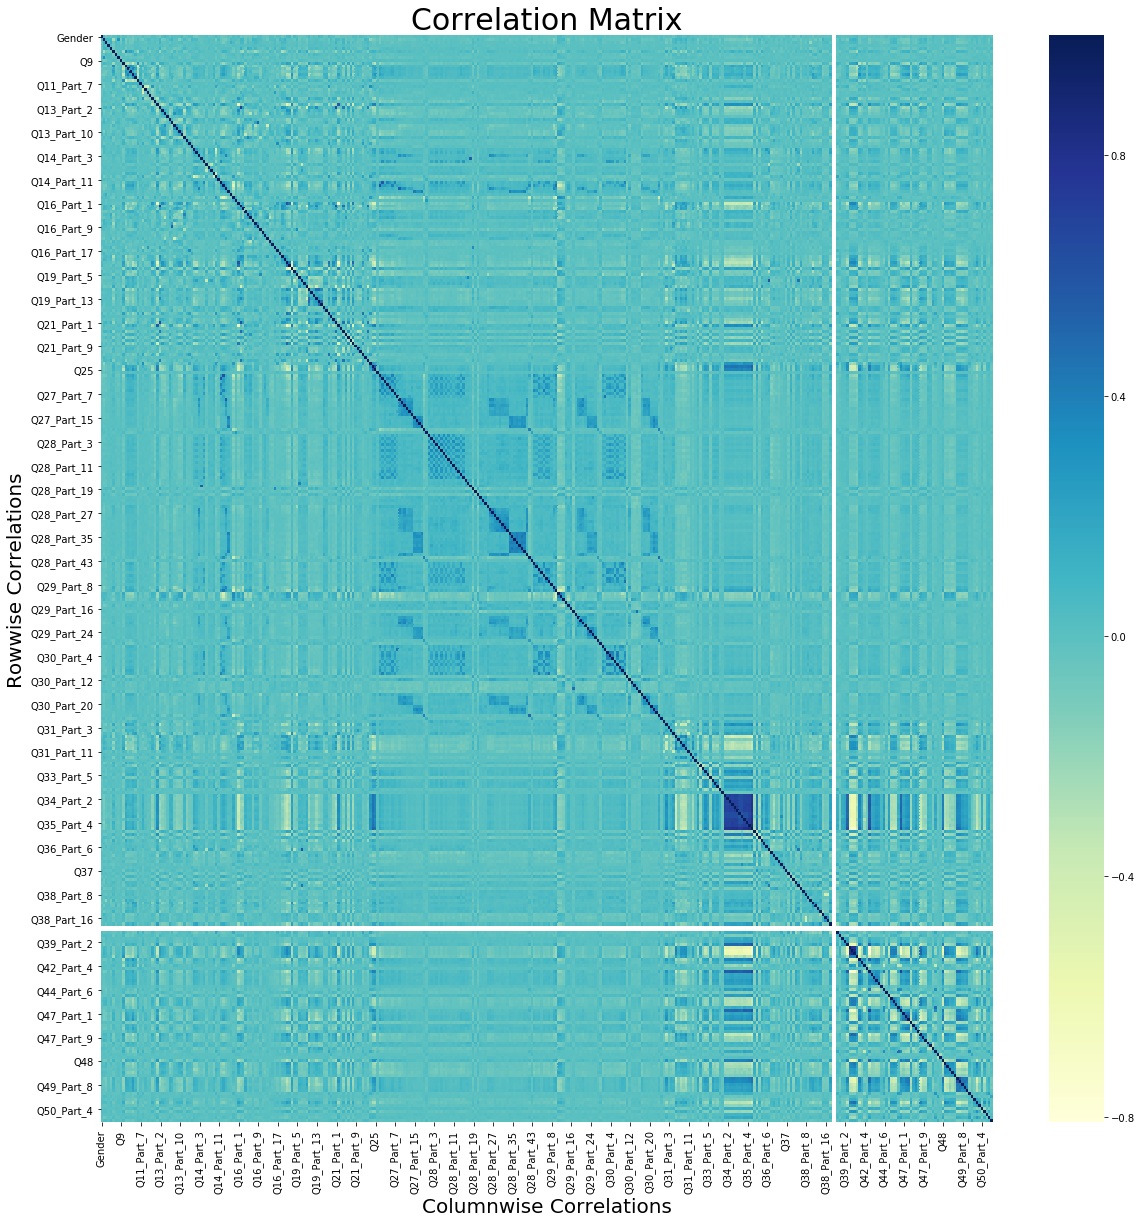

In [42]:
plt.figure(figsize = (20,20))
sns.heatmap(corr,cmap="YlGnBu", xticklabels=8, yticklabels=8)
plt.xlabel('Columnwise Correlations',fontsize=20)
plt.ylabel('Rowwise Correlations',fontsize=20)
plt.title('Correlation Matrix',fontsize=30)

Though the result showing from the heat map was not easy to interpret, it seemed that the first 10 questions had stronger correlations with the yearly compansation.

## Section 3: Feature Selection


#### Why Feature Selection is a useful too in machine learning?
Even after the data cleaning process in Section 1, using all the data from the csv file had a high potential to result a low accuracy model. Since the feature used in the data had strong effect on the model and result. Therefore, in order to have a model with rather high accuracy, the step feature selection was included. With feature selection process, the features that might have strong correlations with the result were selected in order to have a simple yet accurate model.

#### Manually Feature Selection:
Previously in Section 1, the survey questions were divided into 2 categories based on the formats of the question and answers in the csv file. In this section, for feature engineering, the survey questions were to be divided based on the "nature" of the question. For instance, questions like Q7: "In what industry is your current employer/contract (or your most recent employer if retired)?" or Q17: "What specific programming language do you use most often?" were considered "objective" questions, since they asked for the current facts of the person. On the other hand, questions like Q18: "What programming language would you recommend an aspiring data scientist to learn first?" or Q39: "How do you perceive the quality of online learning platforms and in-person bootcamps as compared to the quality of the education provided by traditional brick and mortar institutions?" were considered "subjective" as these questions were more based on the personal opinions. All subjective questions were eliminated, since these responses didn't reflect the actual conditions of the persons taking the survey, so these might affect the accuracy of the model.

In [45]:
subjective_question = ['Q18', 'Q26', 'Q38', 'Q39', 'Q40', 'Q41', 'Q44', 'Q45', 'Q47', 'Q48', 'Q50']

In [47]:
ques = [c for c in salary.columns if c[0:3] not in subjective_question]
salary = salary[ques]

In [54]:
salary.head()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q10,Q11_Part_1,...,Q49_Part_3,Q49_Part_4,Q49_Part_5,Q49_Part_6,Q49_Part_7,Q49_Part_8,Q49_Part_9,Q49_Part_10,Q49_Part_11,Q49_Part_12
1,1,3,22,0,2,11,9,10,1,1,...,0,0,0,1,1,1,1,1,1,0
2,0,3,56,3,1,7,7,0,0,0,...,0,0,0,1,0,0,1,0,1,0
3,1,1,21,3,8,4,7,0,0,1,...,0,0,0,1,1,1,0,1,1,0
4,1,4,8,1,7,11,0,2,1,1,...,1,1,1,1,1,0,1,1,1,0
5,1,0,21,3,7,11,16,0,4,1,...,0,0,0,0,0,1,0,1,1,0


In [49]:
x_train, x_test, y_train, y_test = train_test_split(salary, Y, test_size=0.33, random_state=25)

In [50]:
# feature scaling

from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler()
mms_1 = mms.fit(x_train)
x_train = mms_1.transform(x_train)
x_test = mms_1.transform(x_test)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [51]:
# feature engineering: PCA for development phase, not used

from sklearn.decomposition import PCA

x_train_pca = x_train
x_test_pca = x_test

pca_sel = PCA(n_components=150).fit(x_train_pca)
x_train_pca = pca_sel.transform(x_train_pca)
x_test_pca = pca_sel.transform(x_test_pca)

#### Feature Selection Technique: Lasso
As for the feature selection technique required, LASSO was selected. LASSO, or Least Absolute Shrinkage and Selection Operator, helps to provide a principle way to reduce the number of features in the model by setting a constraint on the total absolute values of the features. Reason for selecting LASSO was that even after cleaning and manual feature selection, the data still had around 300 columns which meant 300 features. With LASSO, it would shrink the coefficients of some variables down to zero, in a way, it reduces the actual features used in the model.  

In [52]:
# feature engineering: Lasso

from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectFromModel

x_train_lasso = x_train
x_test_lasso = x_test
y_train_lasso = y_train

lcv = LassoCV(cv=5)
lasso_sel = SelectFromModel(lcv, threshold=0.00001)
lasso_sel.fit(x_train_lasso, y_train_lasso)
x_train_lasso = lasso_sel.transform(x_train_lasso)
x_test_lasso = lasso_sel.transform(x_test_lasso)

## Section 4: Model Implementation

In [78]:
#set up cross validation

def run_kfold(model, selection): # some of the code were for developing phase
    
    if selection == 1:
        X = pd.DataFrame(x_train_pca)  # train set
    else:
        X = pd.DataFrame(x_train_lasso)
        
    Y = y_train  # train set 

     #   if selection == pca:
       #     X = x_test_pca  # test set
      #  else:
       #     X = x_test_lasso
        
     #   Y = y_test  # test set 

    kf = KFold(n_splits=10) #n_splits previously n_folds
    
    outcomes = []
    fold = 0
    
    for train_index, test_index in kf.split(X):
        fold += 1
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]
        
        model.fit(X_train, Y_train)
        Y_test_predictions = model.predict(X_test)
        
        r_2 = r2_score(Y_test, Y_test_predictions) # can try mean absolute error instead
        outcomes.append(r_2)
        print("Fold {} accuracy: {}".format(fold, r_2))   
    
    
    # r2 score
    mean_outcome = np.mean(outcomes)
    std_outcome = np.std(outcomes)
    print("Mean r2: {}".format(mean_outcome)) # accuracy average
    print("Standard Deviation: {}".format(std_outcome))  # accuracy standard deviation
            
    
    # root mean squared error
    RMSE = np.sqrt(mean_squared_error(Y_test, Y_test_predictions))
    print("Root Mean Squared Error: {}".format(RMSE)) 
    MAE = mean_absolute_error(Y_test,Y_test_predictions)
    print("Mean Absolute Error: {}".format(MAE)) 

In [79]:
# Linear Regression

model_lr = linear_model.LinearRegression()
run_kfold (model_lr, 2)

Fold 1 accuracy: 0.3712413415826781
Fold 2 accuracy: 0.2964882005702508
Fold 3 accuracy: 0.3329548003019075
Fold 4 accuracy: 0.36708256616118584
Fold 5 accuracy: 0.31872684780231353
Fold 6 accuracy: 0.34306284867251213
Fold 7 accuracy: 0.3187059376013829
Fold 8 accuracy: 0.31768762898876035
Fold 9 accuracy: 0.3183338945043346
Fold 10 accuracy: 0.337843337945269
Mean r2: 0.3322127404130594
Standard Deviation: 0.02221094906117476
Root Mean Squared Error: 51709.12929525561
Mean Absolute Error: 31074.852590868428


In [80]:
# SVR

from sklearn.svm import SVR

model_svr = SVR(gamma='auto') # by default to avoid warning messages
run_kfold(model_svr, 2)

Fold 1 accuracy: -0.10501375769855836
Fold 2 accuracy: -0.08447586891580605
Fold 3 accuracy: -0.12404730190628732
Fold 4 accuracy: -0.1069605524002335
Fold 5 accuracy: -0.13112708696340847
Fold 6 accuracy: -0.128749906153107
Fold 7 accuracy: -0.10048370168086351
Fold 8 accuracy: -0.1188282743795428
Fold 9 accuracy: -0.10243108840988291
Fold 10 accuracy: -0.1159478739509281
Mean r2: -0.1118065412458618
Standard Deviation: 0.013817921961872868
Root Mean Squared Error: 67128.78752661617
Mean Absolute Error: 40589.86610242529


In [81]:
# ElasticNet

from sklearn.linear_model import ElasticNet

model_en = ElasticNet()
run_kfold(model_en, 2)

Fold 1 accuracy: 0.18879475121805245
Fold 2 accuracy: 0.14186288040325212
Fold 3 accuracy: 0.14630349370726026
Fold 4 accuracy: 0.19001729144797774
Fold 5 accuracy: 0.1444332551677593
Fold 6 accuracy: 0.17158437606070942
Fold 7 accuracy: 0.15801464356361938
Fold 8 accuracy: 0.14697974891725551
Fold 9 accuracy: 0.1663107634325014
Fold 10 accuracy: 0.16123979161754898
Mean r2: 0.16155409955359365
Standard Deviation: 0.016774758810285544
Root Mean Squared Error: 58197.6914902051
Mean Absolute Error: 37421.82360160713


In [82]:
# Decision Tree 

from sklearn import tree

model_dt = tree.DecisionTreeRegressor()
run_kfold(model_dt, 2)

Fold 1 accuracy: -0.7668066669243649
Fold 2 accuracy: -0.4086617725203927
Fold 3 accuracy: -0.1777308393457766
Fold 4 accuracy: -0.4426610562743376
Fold 5 accuracy: -0.14196228357275165
Fold 6 accuracy: -0.3469721524351206
Fold 7 accuracy: -0.38461016429411776
Fold 8 accuracy: -0.4099609861173059
Fold 9 accuracy: -0.16789033571456624
Fold 10 accuracy: -0.3954538681949491
Mean r2: -0.36427101253936833
Standard Deviation: 0.17225189253736356
Root Mean Squared Error: 75066.22746030545
Mean Absolute Error: 38302.675368007855


In [83]:
# Gradient Boosting 

from sklearn.ensemble import GradientBoostingRegressor

model_gb = GradientBoostingRegressor()
run_kfold(model_gb, 2)

Fold 1 accuracy: 0.539909301094551
Fold 2 accuracy: 0.4060988985784022
Fold 3 accuracy: 0.4182938022082233
Fold 4 accuracy: 0.5052828886980607
Fold 5 accuracy: 0.45799992370815523
Fold 6 accuracy: 0.43864107376129946
Fold 7 accuracy: 0.4303003115703258
Fold 8 accuracy: 0.4031767104492131
Fold 9 accuracy: 0.44204562106600487
Fold 10 accuracy: 0.43025624814950403
Mean r2: 0.447200477928374
Standard Deviation: 0.04149783932547986
Root Mean Squared Error: 47965.24134989888
Mean Absolute Error: 25416.152916829982


In [84]:
''' not used (only for development)
# Bayesian Ridge Regression 

model_brb = linear_model.BayesianRidge()
run_kfold(model_brb, 2)
'''


Fold 1 accuracy: 0.37382834821985655
Fold 2 accuracy: 0.29826089173091674
Fold 3 accuracy: 0.3330918080380946
Fold 4 accuracy: 0.3700884175526149
Fold 5 accuracy: 0.31686060996758747
Fold 6 accuracy: 0.3441499962762231
Fold 7 accuracy: 0.3197766066435873
Fold 8 accuracy: 0.3176616177453254
Fold 9 accuracy: 0.3209062103302277
Fold 10 accuracy: 0.3377055134415271
Mean r2: 0.3332330019945961
Standard Deviation: 0.022830032725826767
Root Mean Squared Error: 51714.510509913795
Mean Absolute Error: 31017.113353149707


The accuracy across the folds for each model were list above under each code.


Below is a table that sums up the results from the 6 selected models.

Model | Mean R2 Score | Standard Deviation | Root Mean Squared Error | Mean Absolute Error
--- | --- | --- | --- | ---
Linear | 0.3322127404130594 | 0.02221094906117476 | 51709.12929525561 | 31074.852590868428
SVR | -0.1118065412458618 | 0.013817921961872868 | 67128.78752661617 | 40589.86610242529
ElasticNet | 0.16155409955359365 | 0.016774758810285544 | 58197.6914902051 | 37421.82360160713
DecisionTree | -0.36427101253936833 | 0.17225189253736356 | 75066.22746030545 | 38302.675368007855
GradientBoosting | 0.447200477928374 | 0.04149783932547986 | 47965.24134989888 | 25416.152916829982

According to the table, Gradient Boosting model has the best performance, as it had the highest mean r2 score and a relatively small standard deviation meaning it fits the actual result the best.

* Linear Regression: It generates a straight line and tries to fit all the points on this line. Pro: This model works on data sets of any size. Con: In reality, linear relations are unlikely to be true. Reason for selection: Easy to implement and its result can privde brief idea of the relations between variables. 
* SVR: It's still a linear model, like linear regression, only that SVR has a boundaries which helps to model to be insensitve to errors. Pro: Easy to implement, can also be used for nonlinear regression by changing the kernal, less sensitive to error. Con: In this case, still used for linear regression. Reason for selection: Previously the linear model recieved acceptable result, so expect SVR to perfect it (failed eventually).
* ElasticNet: A linear model that balance between l1 and l2 regularization at the same time. Pro: Works on data set of any size, use both l1 and l2. Con: In this case, still a linear model. Reason for selection: Previously the SVR model failed, so expect ElasticNet to fix it (failed eventually).
* DecisionTree: This model is in the structure of a tree, as it grows, it breaks down the data set to smaller subsets. Pro: Can work with both numerical and categorical, easy to understand and visualize. Con: Tend to overfit. Reason for selection: Previous linear model all failed, maybe it was time to change to something new (failed eventually).
* GradientBoosting: This produces a model in the form of an ensemble of decision trees. Pro: High performing. Con: Not easy to understand the predictions; a small change in the feature sets could cause a significant change in the model. Reason for selection: Previous decision tree failed, so expect Gradient boosting to fix it since rumor says this model is popular on kaggle.


## Section 5: Model Tuning

In this section, GridSearch was used to perform hyperparameter tuning.

In [85]:
from sklearn.model_selection import GridSearchCV

In [ ]:
# no parameters for linear regression

In [119]:
%%time
# SVR hyperparameter tuning
parameter_svr = {'C': [0.5, 1, 1.5],
                 'gamma': [0.1, 1, 10]
                }
best_svr = GridSearchCV(model_svr, param_grid=parameter_svr, cv=3).fit(x_train_lasso, y_train)

CPU times: user 9min 45s, sys: 5.01 s, total: 9min 50s
Wall time: 10min 4s


In [120]:
best_svr.best_estimator_

SVR(C=1.5, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [122]:
the_best_svr = SVR(C=1.5, gamma=0.1).fit(x_train_lasso, y_train) # set gamma to avoid warning

In [123]:
the_best_svr.score(x_train_lasso, y_train)

-0.11032794192449313

In [100]:
%%time
# ElasticNet hyperparameter tuning
parameter_en = {'l1_ratio': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}
best_en = GridSearchCV(model_en, param_grid=parameter_en, cv=3).fit(x_train_lasso, y_train)


CPU times: user 3.5 s, sys: 137 ms, total: 3.64 s
Wall time: 1.87 s


In [98]:
best_en.best_estimator_

ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.9,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [99]:
the_best_en = ElasticNet(l1_ratio=0.9).fit(x_train_lasso, y_train)
the_best_en.score(x_train_lasso, y_train)

0.26288843787582317

In [102]:

%%time
# Decision Tree hyperparameter tuning
parameter_dt = {'max_depth': list(range(2, 20, 2)),
                'min_samples_split': list(np.linspace(0.1, 1, 10)),
                'min_samples_leaf': list(np.linspace(0.1, 0.5, 5))
               }
best_dt = GridSearchCV(model_dt, param_grid=parameter_dt, cv=3).fit(x_train_lasso, y_train)


CPU times: user 50.6 s, sys: 3.87 s, total: 54.5 s
Wall time: 1min


In [103]:
best_dt.best_estimator_

DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=0.1,
           min_samples_split=0.1, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [106]:
the_best_dt = tree.DecisionTreeRegressor(max_depth=4, 
                                    min_samples_split=0.1, 
                                    min_samples_leaf=0.1).fit(x_train_lasso, y_train)
the_best_dt.score(x_train_lasso, y_train)

0.2966424505615064

n_estimator, min_samples_split and min_sample_leaf were also tried, however, they added the runtime towards "infinity", so they were abandoned. 

In [113]:
%%time
# Gradient Boosting hyperparameter tuning
parameter_gb = {'learning_rate': [0.1, 0.3, 0.5, 0.7, 1],
                'max_depth': list(range(2, 10, 2))
               }
best_gb = GridSearchCV(model_gb, param_grid=parameter_gb, cv=3).fit(x_train_lasso, y_train)

CPU times: user 11min 36s, sys: 5.8 s, total: 11min 42s
Wall time: 11min 54s


In [114]:
best_gb.best_estimator_

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.3, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [227]:
the_best_gb = GradientBoostingRegressor(learning_rate=0.3, max_depth=2).fit(x_train_lasso, y_train)
the_best_gb.score(x_train_lasso, y_train)

0.5144309576657671

In [129]:
'''
%%time
# Bayesian Ridge Regression hyperparameter tuning
parameter_brb = {'alpha_1': [0.0001, 0.00001, 0.000001, 0.0000001, 0.00000001],
                 'alpha_2': [0.0001, 0.00001, 0.000001, 0.0000001, 0.00000001],
                 'lambda_1': [0.0001, 0.00001, 0.000001, 0.0000001, 0.00000001],
                 'lambda_2': [0.0001, 0.00001, 0.000001, 0.0000001, 0.00000001]
    
}
best_brb = GridSearchCV(model_brb, param_grid=parameter_brb, cv=3).fit(x_train_lasso, y_train)
''''''

CPU times: user 5min 51s, sys: 8.16 s, total: 5min 59s
Wall time: 3min 2s


In [130]:
#best_brb.best_estimator_

BayesianRidge(alpha_1=0.0001, alpha_2=0.0001, compute_score=False,
       copy_X=True, fit_intercept=True, lambda_1=1e-08, lambda_2=0.0001,
       n_iter=300, normalize=False, tol=0.001, verbose=False)

In [131]:
#the_best_brb = linear_model.BayesianRidge(alpha_1=0.0001, alpha_2=0.0001, 
 #                                         lambda_1=1e-08, lambda_2=0.0001).fit(x_train_lasso, y_train)
#the_best_brb.score(x_train_lasso, y_train)

0.35123045193453417

Below is the table of models' r2 scores (coefficient of determination) before and after hyperparameter tuning:

Model | R2 Score before tuning | R2 Score after tuning
--- | --- | ---
SVR | -0.1118065412458618 | -0.11032794192449313
ElasticNet | 0.16155409955359365 | 0.26288843787582317
DecisionTree | -0.36427101253936833 | 0.2966424505615064
GradientBoosting | 0.447200477928374 | 0.5144309576657671

It was observed that DecisionTree had the most significant improvement, changing -0.36 (extremely bad fitting) to 0.29. Gradient Boosting still had the best fitting with a coefficient of determination of 0.51. Therefore Gradient Boosting was the best model (I had).

## Section 6: Testing and Discussion

In [141]:
the_best_gb.score(x_test_lasso, y_test)

0.46514763797717795

In [132]:
sorted(list(zip(the_best_gb.feature_importances_, salary)),reverse=True)[0:20]

[(0.3832013482091551, 'Q3'),
 (0.26761219793550045, 'Q2'),
 (0.10261276630820772, 'Q6'),
 (0.05867485321687582, 'Q10'),
 (0.02712656614583341, 'Q7'),
 (0.0142365965937312, 'Q8'),
 (0.013321355155265092, 'Q11_Part_4'),
 (0.012990059179998984, 'Q19_Part_18'),
 (0.012808135595664696, 'Q16_Part_13'),
 (0.01142562099916788, 'Q16_Part_14'),
 (0.009291083474296913, 'Q21_Part_3'),
 (0.008615785380608707, 'Q16_Part_12'),
 (0.008103733631724825, 'Q27_Part_16'),
 (0.0043417777694348195, 'Q21_Part_9'),
 (0.004164760343539077, 'Q16_Part_3'),
 (0.003723464263266544, 'Q19_Part_19'),
 (0.0036114245366222924, 'Q1'),
 (0.0031198391482530137, 'Q16_Part_16'),
 (0.002994353603233008, 'Q13_Part_3'),
 (0.00236662189308959, 'Q13_Part_15')]

The result showed that the model had better performance with the train set, compared to the test set. Either way, the resulting r2 score was not satisfying. Reasons for this might be:
* Base on the graph in Section 2, there were some outliers in the yearly compensation reponses, these might have affected the model, causing over fitting. According to the feature importances above, Q3 (country) had the highest importance, which makes sense, since different countries have different pay rate, and this survey used USD for unit, so people working in developing countries would have noticable lower compensation compared to people working in developed contries.
* LabelEncoder was not good enough as it assumed a 0 < 1 < 2 relations, which is not always true in this data set, for instance the country column (no significant differences between developed countries). Therefore, for future work, OneHotEncoder should also be applied.
* The method for handling missing data might need some improvement.
* The feature selection techniques (not manual interpretation) might need improvement.
* Some other models could be considered, for instance neural networks, LASSO, random forest etc. 